# 1.Environment settings

## 1.1. Connect to google driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2. Import necessary libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import json
import shutil
import glob
import random
import time
import numpy as np
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

from google.colab.patches import cv2_imshow
from PIL import Image
import pandas as pd
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model, load_model

from keras.callbacks import ModelCheckpoint
from keras import backend as K
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def recall_m(y_true, y_pred):
    true_positives = K.clip(y_true * y_pred, 0, 1)
    possible_positives = K.clip(y_true, 0, 1)
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.clip(y_true * y_pred, 0, 1)
    predicted_positives = K.clip(y_pred, 0, 1)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 2.Resize the image to fit the model

In [ ]:
#Go to the data storage location
%cd /content/drive/MyDrive/TomatoLeafDiseaseDataTrain

/content/drive/MyDrive/TomatoLeafDiseaseDataTrain


In [ ]:
#See the internal directory structure
!ls

Bacterial_spot	Septoria_leaf_spot
Early_blight	Spider_mites_Two-spotted_spider_mite
healthy		Target_Spot
Late_blight	TomatoLeafDiseaseDataTrain_Resize
Leaf_Mold	Tomato_mosaic_virus
powdery_mildew	Tomato_Yellow_Leaf_Curl_Virus


In [ ]:
#move to folder to save disease data after resizing
%cd /content/drive/MyDrive/TomatoLeafDiseaseDataTrain/TomatoLeafDiseaseDataTrain_Resize

/content/drive/MyDrive/TomatoLeafDiseaseDataTrain/TomatoLeafDiseaseDataTrain_Resize


In [ ]:
#Create folders to store images after resize
!mkdir Bacterial_spot_Resize
!mkdir Early_blight_Resize
!mkdir healthy_Resize
!mkdir Late_blight_Resize
!mkdir Leaf_Mold_Resize
!mkdir powdery_mildew_Resize
!mkdir Septoria_leaf_spot_Resize
!mkdir Spider_mites_Two-spotted_spider_mite_Resize
!mkdir Target_Spot_Resize
!mkdir Tomato_mosaic_virus_Resize
!mkdir Tomato_Yellow_Leaf_Curl_Virus_Resize

In [ ]:
#Check if folders have been created
!ls

Bacterial_spot_Resize  Septoria_leaf_spot_Resize
Early_blight_Resize    Spider_mites_Two-spotted_spider_mite_Resize
healthy_Resize	       Target_Spot_Resize
Late_blight_Resize     Tomato_mosaic_virus_Resize
Leaf_Mold_Resize       Tomato_Yellow_Leaf_Curl_Virus_Resize
powdery_mildew_Resize


In [ ]:
#Resize images of diseases in each folder and save them in the respective folders created before
for d in ["Bacterial_spot","Early_blight","healthy","Late_blight","Leaf_Mold","powdery_mildew","Septoria_leaf_spot","Spider_mites_Two-spotted_spider_mite","Target_Spot","Tomato_mosaic_virus","Tomato_Yellow_Leaf_Curl_Virus"]:
  for i in glob.glob("./"+d+"/*"):
    img_arr = cv2.imread(i)
    resized_arr = cv2.resize(img_arr, (224, 224))
    y = i.split("/")[-1]
    cv2.imwrite("./"+ d + "_Resize/"+y, resized_arr)

In [ ]:
#Check the data again after resizing
print("Bacterial_spot:",len(os.listdir("./Bacterial_spot_Resize")))
print("Early_blight:",len(os.listdir("./Early_blight_Resize")))
print("healthy:",len(os.listdir("./healthy_Resize")))
print("Late_blight:",len(os.listdir("./Late_blight_Resize")))
print("Leaf_Mold:",len(os.listdir("./Leaf_Mold_Resize")))
print("powdery_mildew:",len(os.listdir("./powdery_mildew_Resize")))
print("Septoria_leaf_spot:",len(os.listdir("./Septoria_leaf_spot_Resize")))
print("Spider_mites_Two-spotted_spider_mite:",len(os.listdir("./Spider_mites_Two-spotted_spider_mite_Resize")))
print("Target_Spot:",len(os.listdir("./Target_Spot_Resize")))
print("Tomato_mosaic_virus:",len(os.listdir("./Tomato_mosaic_virus_Resize")))
print("Tomato_Yellow_Leaf_Curl_Virus:",len(os.listdir("./Tomato_Yellow_Leaf_Curl_Virus_Resize")))

Bacterial_spot: 2826
Early_blight: 2455
healthy: 3051
Late_blight: 3113
Leaf_Mold: 2754
powdery_mildew: 1004
Septoria_leaf_spot: 2882
Spider_mites_Two-spotted_spider_mite: 1747
Target_Spot: 1827
Tomato_mosaic_virus: 2153
Tomato_Yellow_Leaf_Curl_Virus: 2039


# 3.Kmean - K-factor optimization for image segmentation using the elbow method



##3.1. Late_blight

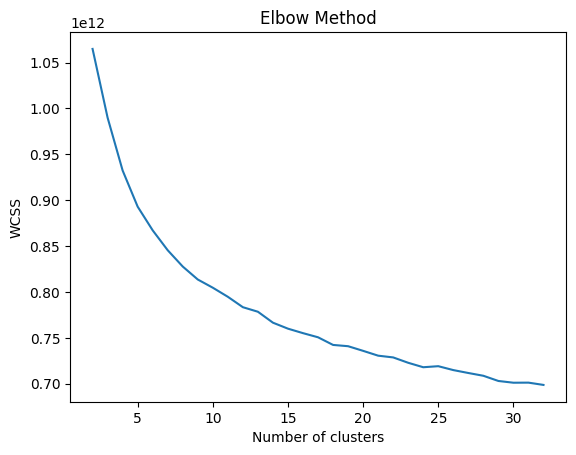

In [ ]:
# Load images and convert to feature vectors
images = []
for i in glob.glob("./Late_blight_Resize"+"/*"):
  images.append(Image.open(i));
data = np.array([np.array(image).flatten() for image in images])

pca = PCA(n_components=1000)
pca.fit(data)
transformed_data = pca.transform(data)
wcss = []
for i in range(2, 33):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(transformed_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 33), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##3.2. Spider_mites_Two-spotted_spider_mite

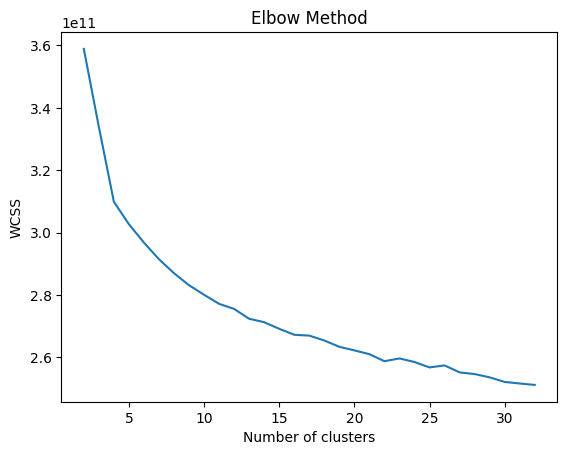

In [ ]:
# Load images and convert to feature vectors
images = []
for i in glob.glob("./Spider_mites_Two-spotted_spider_mite_Resize"+"/*"):
  images.append(Image.open(i));
data = np.array([np.array(image).flatten() for image in images])

pca = PCA(n_components=1000)
pca.fit(data)
transformed_data = pca.transform(data)
wcss = []
for i in range(2, 33):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(transformed_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 33), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##3.3. Tomato_Yellow_Leaf_Curl_Virus

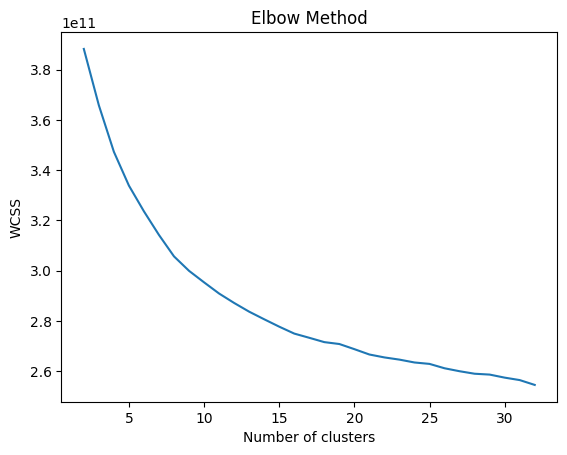

In [ ]:
# Load images and convert to feature vectors
images = []
for i in glob.glob("./Tomato_Yellow_Leaf_Curl_Virus_Resize"+"/*"):
  images.append(Image.open(i));
data = np.array([np.array(image).flatten() for image in images])

pca = PCA(n_components=1000)
pca.fit(data)
transformed_data = pca.transform(data)
wcss = []
for i in range(2, 33):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(transformed_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 33), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#4.Photo preprocessing with K-Mean

In [ ]:
%cd /content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject

/content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject


In [ ]:
!mkdir KMean8
%cd KMean8
# !mkdir Bacterial_spot
# !mkdir Early_blight
# !mkdir healthy
!mkdir Late_blight
# !mkdir Leaf_Mold
# !mkdir powdery_mildew
# !mkdir Septoria_leaf_spot
!mkdir Spider_mites_Two-spotted_spider_mite
# !mkdir Target_Spot
# !mkdir Tomato_mosaic_virus
!mkdir Tomato_Yellow_Leaf_Curl_Virus

/content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject/KMean8


In [ ]:
!ls

Late_blight			      Tomato_Yellow_Leaf_Curl_Virus
Spider_mites_Two-spotted_spider_mite


The kmean method of the cv library has the following parameters:
```
double cv::kmeans(
                    InputArray data,
                    int K,
                    InputOutputArray bestLabels,
                    TermCriteria criteria,
                    int attempts,
                    int flags,
                    OutputArray centers = noArray()
                  )
```

In [ ]:
%cd /content/drive/MyDrive/
!ls

/content/drive/MyDrive
 AppMayBeUse			      HTT-KT
'Colab Notebooks'		      Pictures
 DemoTomatoLeafDiseaseDetectProject   Team11_IS403.N21.HTCL
'Encrypt and Decrypt'		      TomatoLeafDiseaseDataTrain
 Files


In [ ]:
for cl in ["Late_blight","Tomato_Yellow_Leaf_Curl_Virus","Spider_mites_Two-spotted_spider_mite"]:
# for cl in ["Bacterial_spot","Early_blight","healthy","Late_blight","Leaf_Mold","powdery_mildew","Septoria_leaf_spot","Spider_mites_Two-spotted_spider_mite","Target_Spot","Tomato_mosaic_virus","Tomato_Yellow_Leaf_Curl_Virus"]:
  sample = 0
  for i in tqdm(glob.glob("./TomatoLeafDiseaseDataTrain/TomatoLeafDiseaseDataTrain_Resize/"+cl+"_Resize/*")):
    sample = sample + 1
    if(sample > 500):
      break
    picname = i.split("/")[-1]
    original_image = cv2.imread(i)
    for K in [8]:
      img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
      vectorized = img.reshape((-1,3))
      vectorized.shape

      #Chuyển đổi các giá trị unit8 thành float vì nó là yêu cầu của phương thức k-mean của OpenCV.

      vectorized = np.float32(vectorized)
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
      attempts=10

      ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
      center = np.uint8(center)
      res = center[label.flatten()]
      result_image = res.reshape((img.shape))
      convertedimage=cv2.cvtColor(result_image,cv2.COLOR_BGR2RGB)

      #cv2_imshow(convertedimage)
      outputpath = "./DemoTomatoLeafDiseaseDetectProject/KMean"+ str(K)+"/"
      #print(outputpath+cl+"/"+picname)
      cv2.imwrite(outputpath+cl+"/"+picname, convertedimage)

  0%|          | 0/3113 [00:00<?, ?it/s]

  0%|          | 0/2039 [00:00<?, ?it/s]

  0%|          | 0/1747 [00:00<?, ?it/s]

In [ ]:
%cd /content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject
!ls

/content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject
KMean8	Model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
raw = cv2.imread('/content/drive/MyDrive/TomatoLeafDiseaseDataTrain/TomatoLeafDiseaseDataTrain_Resize/Late_blight_Resize/031ab3ab-02f4-4397-9886-54345461580d___RS_Late.B 6654.JPG')
raw=cv2.cvtColor(raw,cv2.COLOR_BGR2RGB)
km8 = cv2.imread('./KMean8/Late_blight/031ab3ab-02f4-4397-9886-54345461580d___RS_Late.B 6654.JPG')
km8=cv2.cvtColor(km8,cv2.COLOR_BGR2RGB)

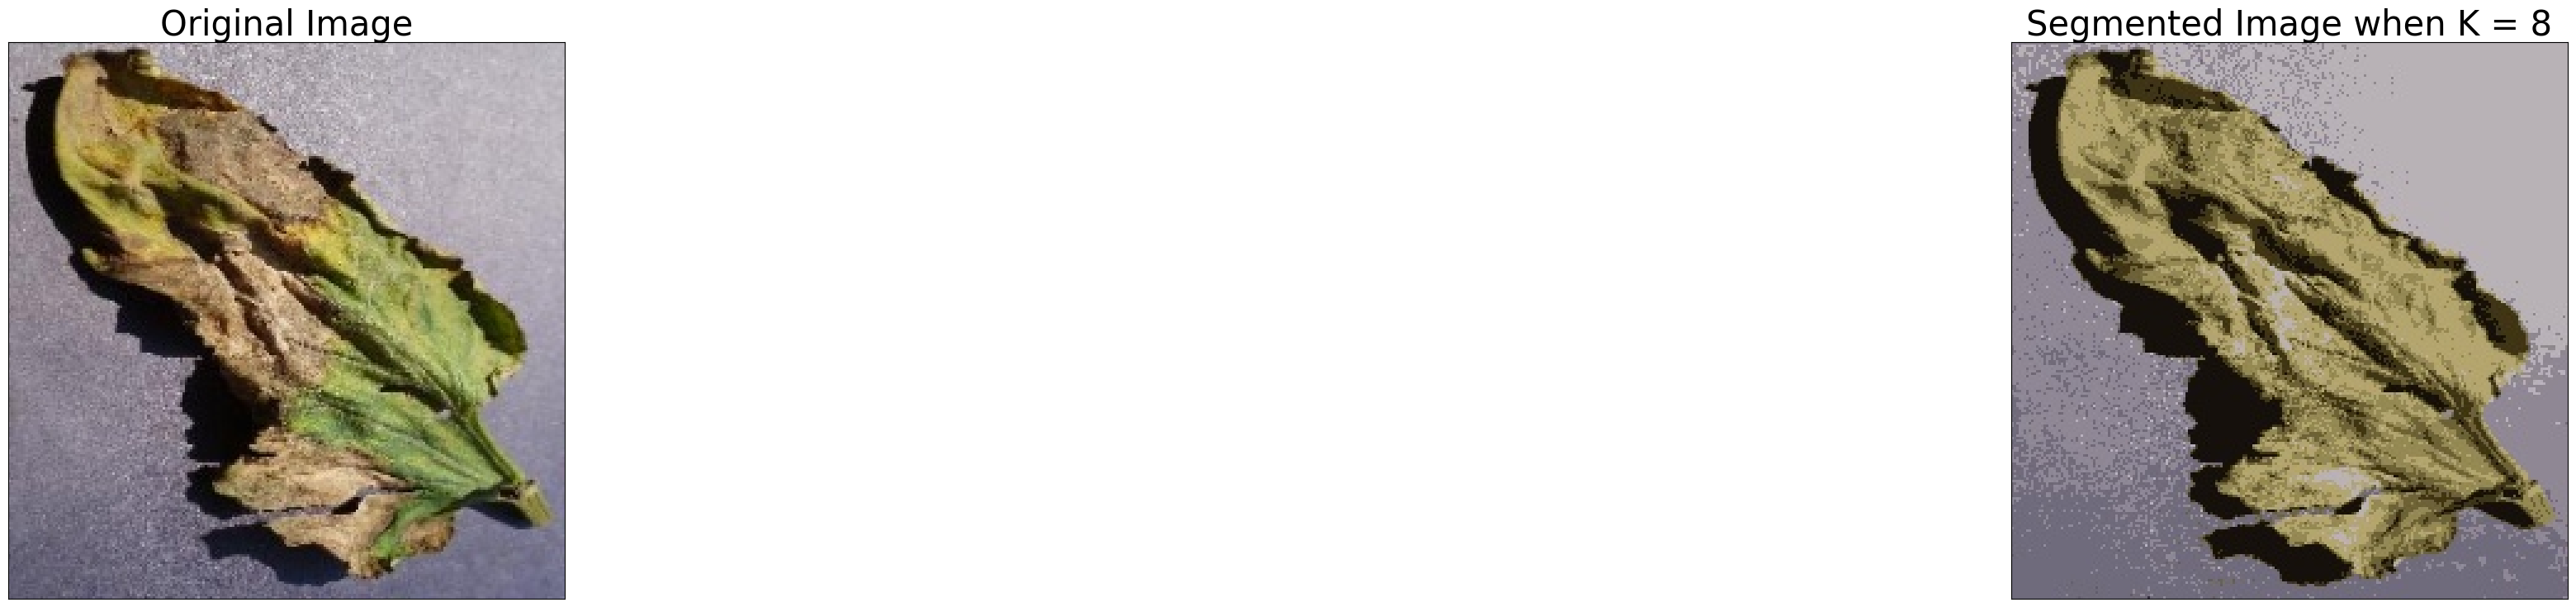

In [ ]:
figure_size = 40
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(2,4,1),plt.imshow(raw)
plt.title('Original Image', fontsize=30), plt.xticks([]), plt.yticks([])
plt.subplot(2,4,4),plt.imshow(km8)
plt.title('Segmented Image when K = 8', fontsize=30), plt.xticks([]), plt.yticks([])
plt.subplots_adjust(hspace=0.000005)
plt.show()

#5.Built Model

In [ ]:
IMG_SIZE = 224

##5.1. VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
def build_model_VGG16(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    model = VGG16(include_top=True, input_tensor=inputs, weights="imagenet")

    model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # Freeze the pretrained weights
    model.trainable = False
    sm = Dense(num_classes, activation="softmax")(model.layers[-1].output)

    model = tf.keras.Model(inputs = model.inputs, outputs = sm)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy",f1_m,precision_m, recall_m], run_eagerly=True
    )
    model.summary()
    return model

##5.2. Propose

In [ ]:
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dense , Dropout , Flatten
from tensorflow.keras.optimizers import Adam

def ProposeModel() :

    model = Sequential()
    #block1
    model.add(Conv2D(filters=64 , kernel_size=(3,3) , padding='same', input_shape=(224,224,3) , activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2) , strides=2, padding='same'))

    #block2
    model.add(Conv2D(filters=128 , kernel_size=(3,3) , padding='same' , activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2) , strides=2, padding='same'))

    #block3
    model.add(Conv2D(filters=256 , kernel_size=(3,3) , padding='same' , activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2) , strides=2, padding='same'))

    #block4
    model.add(Conv2D(filters=512 , kernel_size=(3,3) , padding='same' , activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2) , strides=2, padding='same'))

    #block5
    model.add(Conv2D(filters=512 , kernel_size=(3,3) , padding='same' , activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2) , strides=2, padding='same'))


    model.add(Flatten())

    model.add(Dense(units=512 , activation='relu'))

    model.add(Dense(units=3 , activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy',f1_m,precision_m, recall_m], run_eagerly=True
    )
    model.summary()

    return model

#6.DataSplit + Traning and Verification

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
labels = ["Late_blight","Tomato_Yellow_Leaf_Curl_Virus","Spider_mites_Two-spotted_spider_mite"]
# labels = ["Bacterial_spot","Early_blight","healthy","Late_blight","Leaf_Mold","powdery_mildew","Septoria_leaf_spot","Spider_mites_Two-spotted_spider_mite","Target_Spot","Tomato_mosaic_virus","Tomato_Yellow_Leaf_Curl_Virus"]
X, y = [], []
for i in range(len(labels)):
  path = os.path.join("./DemoTomatoLeafDiseaseDetectProject/KMean8/", labels[i])
  for img in tqdm(os.listdir(path)):
    img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
    X.append(img_arr)
    y.append(i)
  print('Finish for', labels[i])
X = np.array(X)
y = to_categorical(np.array(y), 3)

np.save('./DemoTomatoLeafDiseaseDetectProject/KMean8/X.npy', X, 'wb')
np.save('./DemoTomatoLeafDiseaseDetectProject/KMean8/y.npy', y, 'wb')

print(len(X))
#print(X_train)
print(len(y))
#print(y_train)

  0%|          | 0/500 [00:00<?, ?it/s]

Finish for Late_blight


  0%|          | 0/500 [00:00<?, ?it/s]

Finish for Tomato_Yellow_Leaf_Curl_Virus


  0%|          | 0/500 [00:00<?, ?it/s]

Finish for Spider_mites_Two-spotted_spider_mite
1500
1500


In [ ]:
X=np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/X.npy', mmap_mode = 'r')
y=np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/y.npy',mmap_mode = 'r')

In [ ]:
# Define K-Fold CV
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_idx = 1

for train_ids, val_ids in kfold.split(X, y):

  print("Bắt đầu chia dữ liệu Fold: ", fold_idx)
  np.save('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_train_f'+str(fold_idx)+'.npy', X[train_ids], 'wb')
  np.save('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_train_f'+str(fold_idx)+'.npy', y[train_ids], 'wb')
  np.save('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_val_f'+str(fold_idx)+'.npy', X[val_ids], 'wb')
  np.save('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_val_f'+str(fold_idx)+'.npy', y[val_ids], 'wb')

# Sang Fold tiếp theo
  fold_idx = fold_idx + 1

Bắt đầu chia dữ liệu Fold:  1
Bắt đầu chia dữ liệu Fold:  2
Bắt đầu chia dữ liệu Fold:  3
Bắt đầu chia dữ liệu Fold:  4
Bắt đầu chia dữ liệu Fold:  5


In [ ]:
for t in range(1,6):
  print("Fold"+str(t)+": ")
  # Bacterial_spott=0
  # Early_blightt=0
  # healthyt=0
  Late_blightt=0
  # Leaf_Moldt=0
  # powdery_mildewt=0
  # Septoria_leaf_spott=0
  Spider_mites_Twospotted_spider_mitet=0
  # Target_Spott=0
  # Tomato_mosaic_virust=0
  Tomato_Yellow_Leaf_Curl_Virust=0

  # Bacterial_spotv=0
  # Early_blightv=0
  # healthyv=0
  Late_blightv=0
  # Leaf_Moldv=0
  # powdery_mildewv=0
  # Septoria_leaf_spotv=0
  Spider_mites_Twospotted_spider_mitev=0
  # Target_Spotv=0
  # Tomato_mosaic_virusv=0
  Tomato_Yellow_Leaf_Curl_Virusv=0
  print("Train")

  X_train=np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_train_f'+str(t)+'.npy', mmap_mode = 'r')
  y_train=np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_train_f'+str(t)+'.npy',mmap_mode = 'r')
  len(X_train)
  len(y_train)
  for i in y_train:
    if(i[0]==1):
      Late_blightt=Late_blightt+1
    if(i[1]==1):
      Spider_mites_Twospotted_spider_mitet=Spider_mites_Twospotted_spider_mitet+1
    if(i[2]==1):
      Tomato_Yellow_Leaf_Curl_Virust=Tomato_Yellow_Leaf_Curl_Virust+1

    # if(i[0]==1):
    #   Bacterial_spott=Bacterial_spott+1
    # if(i[1]==1):
    #   Early_blightt=Early_blightt+1
    # if(i[2]==1):
    #   healthyt=healthyt+1
    # if(i[3]==1):
    #   Late_blightt=Late_blightt+1
    # if(i[4]==1):
    #   Leaf_Moldt=Leaf_Moldt+1
    # if(i[5]==1):
    #   powdery_mildewt=powdery_mildewt+1
    # if(i[6]==1):
    #   Septoria_leaf_spott=Septoria_leaf_spott+1
    # if(i[7]==1):
    #   Spider_mites_Twospotted_spider_mitet=Spider_mites_Twospotted_spider_mitet+1
    # if(i[8]==1):
    #   Target_Spott=Target_Spott+1
    # if(i[9]==1):
    #   Tomato_mosaic_virust=Tomato_mosaic_virust+1
    # if(i[10]==1):
    #   Tomato_Yellow_Leaf_Curl_Virust=Tomato_Yellow_Leaf_Curl_Virust+1

  #print("Bacterial_spot trian: ",Bacterial_spott)
  # print("Early_blight train: ",Early_blightt)
  # print("healthy train: ",healthyt)
  print("Late_blight train: ",Late_blightt)
  # print("Leaf_Mold train: ",Leaf_Moldt)
  # print("powdery_mildew train: ",powdery_mildewt)
  # print("Septoria_leaf_spot train: ",Septoria_leaf_spott)
  print("Spider_mites_Two-spotted_spider_mite train: ",Spider_mites_Twospotted_spider_mitet)
  # print("Target_Spot train: ",Target_Spott)
  # print("Tomato_mosaic_virus train: ",Tomato_mosaic_virust)
  print("Tomato_Yellow_Leaf_Curl_Virus train: ",Tomato_Yellow_Leaf_Curl_Virust)

  print("Val")

  X_val=np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_val_f'+str(t)+'.npy', mmap_mode = 'r')
  y_val=np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_val_f'+str(t)+'.npy', mmap_mode = 'r')
  len(X_val)
  len(y_val)
  for i in y_val:
    if(i[0]==1):
      Late_blightv=Late_blightv+1
    if(i[1]==1):
      Spider_mites_Twospotted_spider_mitev=Spider_mites_Twospotted_spider_mitev+1
    if(i[2]==1):
      Tomato_Yellow_Leaf_Curl_Virusv=Tomato_Yellow_Leaf_Curl_Virusv+1

    # if(i[0]==1):
    #   Bacterial_spotv=Bacterial_spotv+1
    # if(i[1]==1):
    #   Early_blightv=Early_blightv+1
    # if(i[2]==1):
    #   healthyv=healthyv+1
    # if(i[3]==1):
    #   Late_blightv=Late_blightv+1
    # if(i[4]==1):
    #   Leaf_Moldv=Leaf_Moldv+1
    # if(i[5]==1):
    #   powdery_mildewv=powdery_mildewv+1
    # if(i[6]==1):
    #   Septoria_leaf_spotv=Septoria_leaf_spotv+1
    # if(i[7]==1):
    #   Spider_mites_Twospotted_spider_mitev=Spider_mites_Twospotted_spider_mitev+1
    # if(i[8]==1):
    #   Target_Spotv=Target_Spotv+1
    # if(i[9]==1):
    #   Tomato_mosaic_virusv=Tomato_mosaic_virusv+1
    # if(i[10]==1):
    #   Tomato_Yellow_Leaf_Curl_Virusv=Tomato_Yellow_Leaf_Curl_Virusv+1

  # print("Bacterial_spot val: ",Bacterial_spotv)
  # print("Early_blight val: ",Early_blightv)
  # print("healthy val: ",healthyv)
  print("Late_blight val: ",Late_blightv)
  # print("Leaf_Mold val: ",Leaf_Moldv)
  # print("powdery_mildew val: ",powdery_mildewv)
  # print("Septoria_leaf_spot val: ",Septoria_leaf_spotv)
  print("Spider_mites_Two-spotted_spider_mite val: ",Spider_mites_Twospotted_spider_mitev)
  # print("Target_Spot val: ",Target_Spotv)
  # print("Tomato_mosaic_virus val: ",Tomato_mosaic_virusv)
  print("Tomato_Yellow_Leaf_Curl_Virus val: ",Tomato_Yellow_Leaf_Curl_Virusv)

Fold1: 
Train
Late_blight train:  376
Spider_mites_Two-spotted_spider_mite train:  409
Tomato_Yellow_Leaf_Curl_Virus train:  415
Val
Late_blight val:  124
Spider_mites_Two-spotted_spider_mite val:  91
Tomato_Yellow_Leaf_Curl_Virus val:  85
Fold2: 
Train
Late_blight train:  403
Spider_mites_Two-spotted_spider_mite train:  402
Tomato_Yellow_Leaf_Curl_Virus train:  395
Val
Late_blight val:  97
Spider_mites_Two-spotted_spider_mite val:  98
Tomato_Yellow_Leaf_Curl_Virus val:  105
Fold3: 
Train
Late_blight train:  409
Spider_mites_Two-spotted_spider_mite train:  390
Tomato_Yellow_Leaf_Curl_Virus train:  401
Val
Late_blight val:  91
Spider_mites_Two-spotted_spider_mite val:  110
Tomato_Yellow_Leaf_Curl_Virus val:  99
Fold4: 
Train
Late_blight train:  397
Spider_mites_Two-spotted_spider_mite train:  405
Tomato_Yellow_Leaf_Curl_Virus train:  398
Val
Late_blight val:  103
Spider_mites_Two-spotted_spider_mite val:  95
Tomato_Yellow_Leaf_Curl_Virus val:  102
Fold5: 
Train
Late_blight train:  415
S

#7.Experiment Model Propose

##7.1. Training

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
fold =1

In [ ]:
X_train = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_train_f'+str(fold)+'.npy', mmap_mode = 'r')
y_train = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_train_f'+str(fold)+'.npy', mmap_mode = 'r')
X_val = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_val_f'+str(fold)+'.npy', mmap_mode = 'r')
y_val = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_val_f'+str(fold)+'.npy', mmap_mode = 'r')

In [ ]:
# scale pixels
def normalize(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
X_train, X_val = normalize(X_train, X_val)

In [ ]:
print('KMean8_Proposed_'+str(fold))
model = ProposeModel()

start = time.time()
# Train model
hist = model.fit(X_train, y_train,
            batch_size=0,
            epochs=10,
            verbose=1)
end = time.time()
print('Training time: ', end - start)
# Test và in kết quả


print("Save model Fold ", fold)
prefix = "/content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject/Model/"
name = 'KMean8_Proposed_'+str(fold)
print(prefix + name + '.h5')
model.save(prefix + name + '.h5')
print('Đã lưu mô hình!')



# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(hist.history)
# or save to csv:
hist_csv_file = prefix + name +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
print("Đã lưu lịch sử!")

accuracy_list = []
loss_list = []
f1_score_list = []
precision_list = []
recall_list = []
scores = model.evaluate(X_val, y_val, verbose=0)


print("Kết quả fold ", fold)

# Thêm thông tin accuracy và loss vào list
accuracy_list.append(scores[1] * 100)
loss_list.append(scores[0])

# Sang Fold tiếp theo
print('* Chi tiết các fold')
for i in range(0, len(accuracy_list)):
  print(f'> Fold {i+1} - Loss: {loss_list[i]} - Accuracy: {accuracy_list[i]}%')

print('* Đánh giá tổng thể các folds:')
print(f'> Accuracy: {np.mean(accuracy_list)} (Độ lệch +- {np.std(accuracy_list)})')
print(f'> Loss: {np.mean(loss_list)}')

print("Đã đánh giá xong")

KMean8_Proposed_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2

##7.2. Evaluating Model

In [ ]:
model = load_model('/content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject/Model/KMean8_Proposed_1.h5', custom_objects={'f1_m':f1_m,'precision_m': precision_m, 'recall_m': recall_m}, compile = True)

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


10/10 [==============================] - 47s 5s/step
accuracy: 0.2833333333333333
                                      precision    recall  f1-score  support
Late_blight                            0.000000  0.000000  0.000000    124.0
Tomato_Yellow_Leaf_Curl_Virus          0.000000  0.000000  0.000000     91.0
Spider_mites_Two-spotted_spider_mite   0.283333  1.000000  0.441558     85.0
micro avg                              0.283333  0.283333  0.283333    300.0
macro avg                              0.094444  0.333333  0.147186    300.0
weighted avg                           0.080278  0.283333  0.125108    300.0
samples avg                            0.283333  0.283333  0.283333    300.0


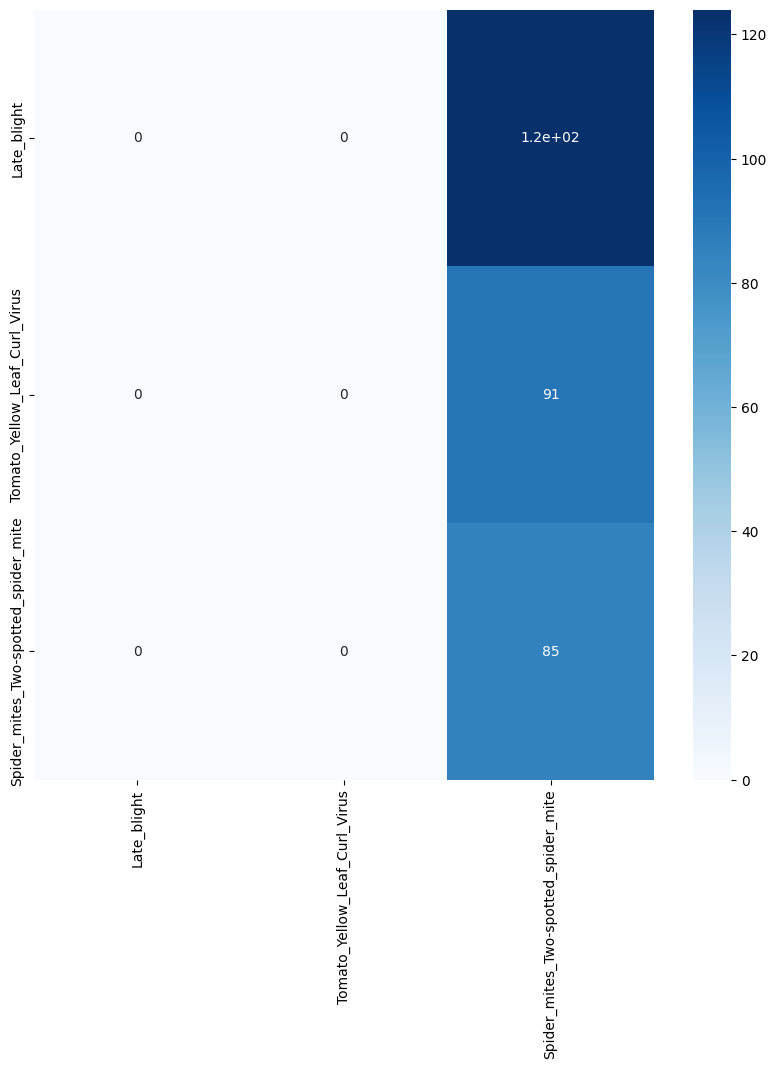

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

labels =  ["Late_blight","Tomato_Yellow_Leaf_Curl_Virus","Spider_mites_Two-spotted_spider_mite"]

y_val_pred_pro = model.predict(X_val)
y_val_pred= np.argmax(y_val_pred_pro, axis = 1)
y_val_pred = np.eye(3)[y_val_pred]
#print(y_val_pred)
#print(y_val)
print("accuracy: " + str(accuracy_score(y_val, y_val_pred)))
report  = classification_report(y_val, y_val_pred, target_names = labels, output_dict = True)
report = pd.DataFrame(report).T
print(report)
#report.to_csv('VGG16_logistic.csv')
#report

import seaborn as sns
from sklearn.metrics import confusion_matrix


# from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1)),
            cmap="Blues", annot = True, annot_kws = {"size": 10},
            xticklabels = labels, yticklabels = labels)
plt.show()

###7.2.1. ROC

In [ ]:
y_val_Late_blight=[]
y_val_Tomato_Yellow_Leaf_Curl_Virus=[]
y_val_Spider_mites_Two_spotted_spider_mite=[]
for i in y_val:
  y_val_Late_blight.append(i[0])
  y_val_Tomato_Yellow_Leaf_Curl_Virus.append(i[1])
  y_val_Spider_mites_Two_spotted_spider_mite.append(i[2])
y_val_pred_pro_Late_blight = y_val_pred_pro[:, 0]
y_val_pred_pro_Tomato_Yellow_Leaf_Curl_Virus = y_val_pred_pro[:, 1]
y_val_pred_pro_Spider_mites_Two_spotted_spider_mite = y_val_pred_pro[:, 2]

In [ ]:
# calculate roc curves
Late_blight_fpr, Late_blight_tpr, Late_blight_thresholds = roc_curve(y_val_Late_blight, y_val_pred_pro_Late_blight)
Tomato_Yellow_Leaf_Curl_Virus_fpr, Tomato_Yellow_Leaf_Curl_Virus_tpr, Tomato_Yellow_Leaf_Curl_Virus_thresholds = roc_curve(y_val_Tomato_Yellow_Leaf_Curl_Virus, y_val_pred_pro_Tomato_Yellow_Leaf_Curl_Virus)
Spider_mites_Two_spotted_spider_mite_fpr, Spider_mites_Two_spotted_spider_mite_tpr, Spider_mites_Two_spotted_spider_mite_thresholds = roc_curve(y_val_Spider_mites_Two_spotted_spider_mite, y_val_pred_pro_Spider_mites_Two_spotted_spider_mite)
i = 0
middleline = []
while(i<=1):
  middleline.append(i)
  i = i + 0.1

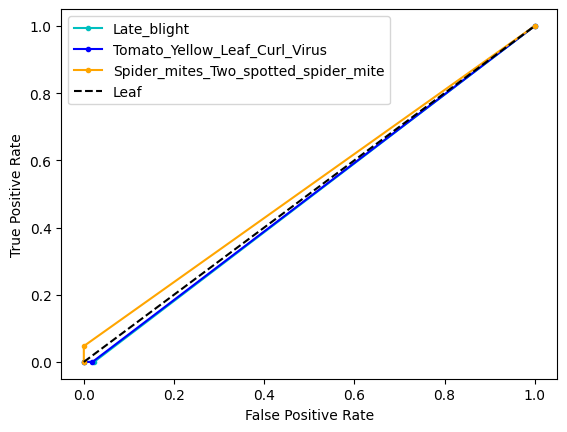

In [ ]:
# plot the roc curve for the model
pyplot.plot(Late_blight_fpr, Late_blight_tpr, marker='.',color='c', label='Late_blight')
pyplot.plot(Tomato_Yellow_Leaf_Curl_Virus_fpr, Tomato_Yellow_Leaf_Curl_Virus_tpr, marker='.',color='b', label='Tomato_Yellow_Leaf_Curl_Virus')
pyplot.plot(Spider_mites_Two_spotted_spider_mite_fpr, Spider_mites_Two_spotted_spider_mite_tpr, marker='.',color='orange', label='Spider_mites_Two_spotted_spider_mite')
pyplot.plot(middleline, middleline,linestyle='--',color='black', label='Leaf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

###7.2.2. Predict image

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:

labels = ["Late_blight","Tomato_Yellow_Leaf_Curl_Virus","Spider_mites_Two-spotted_spider_mite"]
X, y = [], []
for img in tqdm(os.listdir("/content/drive/MyDrive/IMAGE_TEST")):
    print(img)
    img_arr = cv2.imread(os.path.join("/content/drive/MyDrive/IMAGE_TEST", img))[...,::-1]
    resized_arr = cv2.resize(img_arr, (224, 224))
    X.append(resized_arr)
X = np.array(X)

  0%|          | 0/2 [00:00<?, ?it/s]

0b6caac4-cc62-4c46-9de4-1815a0aa6dbe___GHLB2 Leaf 8799_flipLR.JPG
451819a3-0ec8-4716-bf0e-76fdb6c2353d___YLCV_NREC 2542.JPG


In [ ]:
X = X.astype('float32')

In [ ]:
y_val_pred_pro = model.predict(X)
y_val_pred= np.argmax(y_val_pred_pro, axis = 1)
y_val_pred = np.eye(3)[y_val_pred]

1/1 [==============================] - 1s 573ms/step


Lá cà chua đang mắc bệnh Tomato_Yellow_Leaf_Curl_Virus với xác suất:  0.37826538 !!!


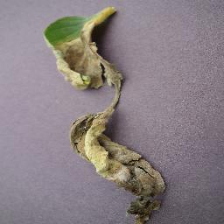

Lá cà chua đang mắc bệnh Tomato_Yellow_Leaf_Curl_Virus với xác suất:  0.37826538 !!!


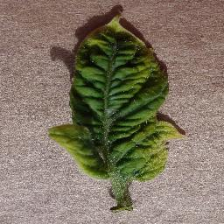

In [ ]:
for i in range(len(X)):
  if(y_val_pred[i][0] == 1):
    print("Lá cà chua đang mắc bệnh Late_blight với xác suất: ", y_val_pred_pro[i][0], "!!!")
  if(y_val_pred[i][1] == 1):
    print("Lá cà chua đang mắc bệnh Spider_mites Two-spotted_spider_mite với xác suất: ", y_val_pred_pro[i][1], "!!!")
  if(y_val_pred[i][2] == 1):
    print("Lá cà chua đang mắc bệnh Tomato_Yellow_Leaf_Curl_Virus với xác suất: ", y_val_pred_pro[i][2], "!!!")
  RGB_img = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
  cv2_imshow(RGB_img)

#8.Experiment Model VGG16

##8.1. Tranning

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
fold = 5

In [ ]:
X_train = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_train_f'+str(fold)+'.npy', mmap_mode = 'r')
y_train = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_train_f'+str(fold)+'.npy', mmap_mode = 'r')
X_val = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/X_val_f'+str(fold)+'.npy', mmap_mode = 'r')
y_val = np.load('./DemoTomatoLeafDiseaseDetectProject/KMean8/y_val_f'+str(fold)+'.npy', mmap_mode = 'r')

In [ ]:
# scale pixels
def normalize(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [ ]:
X_train, X_val = normalize(X_train, X_val)

In [ ]:
print('KMean8_VGG16_'+str(fold))
model = build_model_VGG16(3)

start = time.time()
# Train model
hist = model.fit(X_train, y_train,
            batch_size=0,
            epochs=3,
            verbose=1)
end = time.time()
print('Training time: ', end - start)
# Test và in kết quả


print("Save model Fold ", fold)
prefix = "/content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject/Model/"
name = 'KMean8_VGG16_'+str(fold)
print(prefix + name + '.h5')
model.save(prefix + name + '.h5')
print('Đã lưu mô hình!')



# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(hist.history)
# or save to csv:
hist_csv_file = prefix + name +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
print("Đã lưu lịch sử!")

accuracy_list = []
loss_list = []
f1_score_list = []
precision_list = []
recall_list = []
scores = model.evaluate(X_val, y_val, verbose=0)


print("Kết quả fold ", fold)

# Thêm thông tin accuracy và loss vào list
accuracy_list.append(scores[1] * 100)
loss_list.append(scores[0])

# Sang Fold tiếp theo
print('* Chi tiết các fold')
for i in range(0, len(accuracy_list)):
  print(f'> Fold {i+1} - Loss: {loss_list[i]} - Accuracy: {accuracy_list[i]}%')

print('* Đánh giá tổng thể các folds:')
print(f'> Accuracy: {np.mean(accuracy_list)} (Độ lệch +- {np.std(accuracy_list)})')
print(f'> Loss: {np.mean(loss_list)}')

print("Đã đánh giá xong")

KMean8_VGG16_5
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 

##8.2. Evaluating Model

In [ ]:
model = load_model('/content/drive/MyDrive/DemoTomatoLeafDiseaseDetectProject/Model/KMean8_VGG16_5.h5', custom_objects={'f1_m':f1_m,'precision_m': precision_m, 'recall_m': recall_m}, compile = True)

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


10/10 [==============================] - 235s 24s/step
accuracy: 0.7933333333333333
                                      precision    recall  f1-score  support
Late_blight                            0.878378  0.764706  0.817610     85.0
Tomato_Yellow_Leaf_Curl_Virus          0.917808  0.632075  0.748603    106.0
Spider_mites_Two-spotted_spider_mite   0.692810  0.972477  0.809160    109.0
micro avg                              0.793333  0.793333  0.793333    300.0
macro avg                              0.829666  0.789753  0.791791    300.0
weighted avg                           0.824887  0.793333  0.790158    300.0
samples avg                            0.793333  0.793333  0.793333    300.0


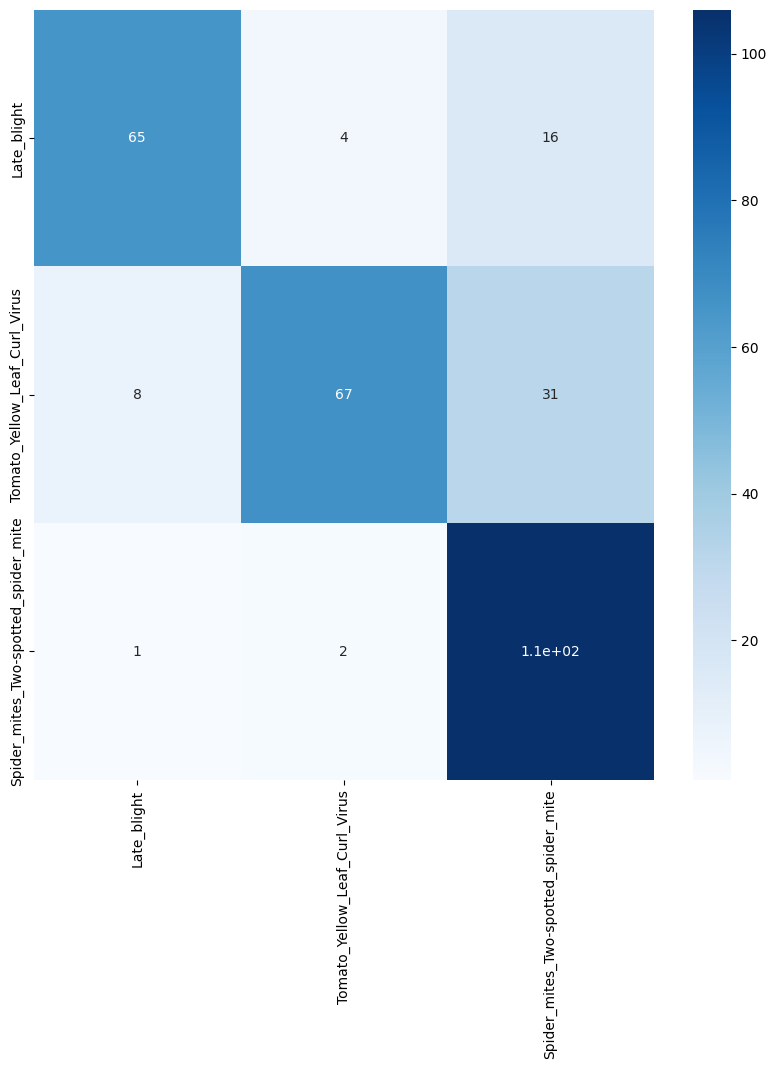

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

labels =  ["Late_blight","Tomato_Yellow_Leaf_Curl_Virus","Spider_mites_Two-spotted_spider_mite"]

y_val_pred_pro = model.predict(X_val)
y_val_pred= np.argmax(y_val_pred_pro, axis = 1)
y_val_pred = np.eye(3)[y_val_pred]
#print(y_val_pred)
#print(y_val)
print("accuracy: " + str(accuracy_score(y_val, y_val_pred)))
report  = classification_report(y_val, y_val_pred, target_names = labels, output_dict = True)
report = pd.DataFrame(report).T
print(report)
#report.to_csv('VGG16_logistic.csv')
#report

import seaborn as sns
from sklearn.metrics import confusion_matrix


# from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1)),
            cmap="Blues", annot = True, annot_kws = {"size": 10},
            xticklabels = labels, yticklabels = labels)
plt.show()

###8.2.1. ROC

In [ ]:
y_val_Late_blight=[]
y_val_Tomato_Yellow_Leaf_Curl_Virus=[]
y_val_Spider_mites_Two_spotted_spider_mite=[]
for i in y_val:
  y_val_Late_blight.append(i[0])
  y_val_Tomato_Yellow_Leaf_Curl_Virus.append(i[1])
  y_val_Spider_mites_Two_spotted_spider_mite.append(i[2])
y_val_pred_pro_Late_blight = y_val_pred_pro[:, 0]
y_val_pred_pro_Tomato_Yellow_Leaf_Curl_Virus = y_val_pred_pro[:, 1]
y_val_pred_pro_Spider_mites_Two_spotted_spider_mite = y_val_pred_pro[:, 2]

In [ ]:
# calculate roc curves
Late_blight_fpr, Late_blight_tpr, Late_blight_thresholds = roc_curve(y_val_Late_blight, y_val_pred_pro_Late_blight)
Tomato_Yellow_Leaf_Curl_Virus_fpr, Tomato_Yellow_Leaf_Curl_Virus_tpr, Tomato_Yellow_Leaf_Curl_Virus_thresholds = roc_curve(y_val_Tomato_Yellow_Leaf_Curl_Virus, y_val_pred_pro_Tomato_Yellow_Leaf_Curl_Virus)
Spider_mites_Two_spotted_spider_mite_fpr, Spider_mites_Two_spotted_spider_mite_tpr, Spider_mites_Two_spotted_spider_mite_thresholds = roc_curve(y_val_Spider_mites_Two_spotted_spider_mite, y_val_pred_pro_Spider_mites_Two_spotted_spider_mite)
i = 0
middleline = []
while(i<=1):
  middleline.append(i)
  i = i + 0.1

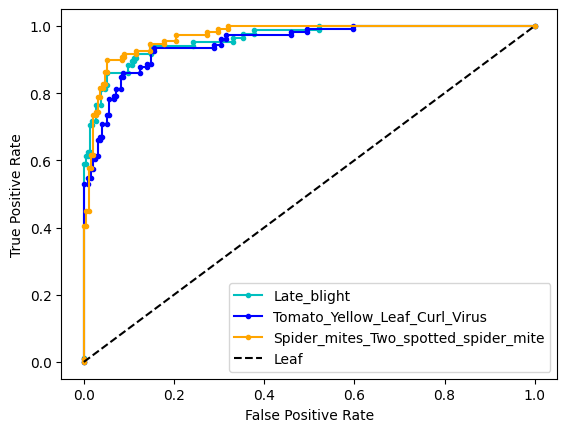

In [ ]:
# plot the roc curve for the model
pyplot.plot(Late_blight_fpr, Late_blight_tpr, marker='.',color='c', label='Late_blight')
pyplot.plot(Tomato_Yellow_Leaf_Curl_Virus_fpr, Tomato_Yellow_Leaf_Curl_Virus_tpr, marker='.',color='b', label='Tomato_Yellow_Leaf_Curl_Virus')
pyplot.plot(Spider_mites_Two_spotted_spider_mite_fpr, Spider_mites_Two_spotted_spider_mite_tpr, marker='.',color='orange', label='Spider_mites_Two_spotted_spider_mite')
pyplot.plot(middleline, middleline,linestyle='--',color='black', label='Leaf')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

###8.2.2. Predict image

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
labels = ["Late_blight","Tomato_Yellow_Leaf_Curl_Virus","Spider_mites_Two-spotted_spider_mite"]
X, y = [], []
for img in tqdm(os.listdir("/content/drive/MyDrive/IMAGE_TEST")):
    print(img)
    img_arr = cv2.imread(os.path.join("/content/drive/MyDrive/IMAGE_TEST", img))[...,::-1]
    resized_arr = cv2.resize(img_arr, (224, 224))
    X.append(resized_arr)
X = np.array(X)

  0%|          | 0/2 [00:00<?, ?it/s]

0b6caac4-cc62-4c46-9de4-1815a0aa6dbe___GHLB2 Leaf 8799_flipLR.JPG
451819a3-0ec8-4716-bf0e-76fdb6c2353d___YLCV_NREC 2542.JPG


In [ ]:
X = X.astype('float32')

In [ ]:
y_val_pred_pro = model.predict(X)
y_val_pred= np.argmax(y_val_pred_pro, axis = 1)
y_val_pred = np.eye(3)[y_val_pred]

1/1 [==============================] - 2s 2s/step


Lá cà chua đang mắc bệnh Late_blight với xác suất:  0.99999964 !!!


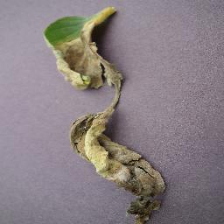

Lá cà chua đang mắc bệnh Spider_mites Two-spotted_spider_mite với xác suất:  0.8371891 !!!


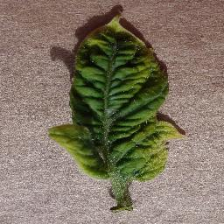

In [ ]:
for i in range(len(X)):
  if(y_val_pred[i][0] == 1):
    print("Lá cà chua đang mắc bệnh Late_blight với xác suất: ", y_val_pred_pro[i][0], "!!!")
  if(y_val_pred[i][1] == 1):
    print("Lá cà chua đang mắc bệnh Spider_mites Two-spotted_spider_mite với xác suất: ", y_val_pred_pro[i][1], "!!!")
  if(y_val_pred[i][2] == 1):
    print("Lá cà chua đang mắc bệnh Tomato_Yellow_Leaf_Curl_Virus với xác suất: ", y_val_pred_pro[i][2], "!!!")
  RGB_img = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)
  cv2_imshow(RGB_img)